<a href="https://colab.research.google.com/github/fatsed/CustomerSupportToneChecker/blob/main/notebooks/02_ToneDetection_api_ui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-Load Dataset




In [1]:
!git clone https://github.com/fatsed/CustomerSupportToneChecker.git

Cloning into 'CustomerSupportToneChecker'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 140 (delta 63), reused 37 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 746.32 KiB | 5.83 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [2]:
%cd /content/CustomerSupportToneChecker/notebooks

/content/CustomerSupportToneChecker/notebooks


In [3]:
#load dataset
import os
import pandas as pd

BASE_DIR = os.path.abspath("..")
DATA_PATH = os.path.join(BASE_DIR, "dataset", "tone_dataset.csv")

print("BASE_DIR:", BASE_DIR)
print("DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("✅ Dataset loaded.")
print("Shape:", df.shape)
df.head()

BASE_DIR: /content/CustomerSupportToneChecker
DATA_PATH: /content/CustomerSupportToneChecker/dataset/tone_dataset.csv
✅ Dataset loaded.
Shape: (300, 3)


,id,text,label
0,1,سلام وقت بخیر. می‌خواستم وضعیت سفارش شماره ۱۲۳...,polite
1,2,سلام و عرض ادب. لطفاً زمان تقریبی ارسال بسته م...,polite
2,3,با سلام. ممنون می‌شم اگر کد رهگیری را برای بند...,polite
3,4,روزتون بخیر. امکانش هست وضعیت مرسوله را بررسی ...,polite
4,5,سلام. ممنون می‌شم اگر راهنمایی کنید چطور می‌تو...,polite


#2-Preprocessing

In [10]:
!pip install gensim python-crfsuite fasttext flashtext && pip install hazm --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498213 sha256=b288ed5a5d234102ff14a35b78212470e504aec78368d9397724a9372b9d371a
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9300 sha256=9ecadf80107dfe01b3806ad3d38ecf9ae6c7d68b239a11caa58772e2977cc089
  Stored in directory: /root/.cache/

In [11]:
from hazm import Normalizer, word_tokenize, stopwords_list
import re

normalizer = Normalizer()
stopwords = set(stopwords_list())

def clean_text(text: str) -> str:
    text = str(text)
    # 1) Normalize
    text = normalizer.normalize(text)
    # 2) Remove letters and numbers
    text = re.sub(r"[A-Za-z0-9۰-۹]", " ", text)
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    # 3) Tokenize
    tokens = word_tokenize(text)
    # 4) Remove stopwords + very short tokens
    tokens = [t for t in tokens if t not in stopwords and len(t) > 1]
    # 5) ⚠️ NO STEMMING, NO LEMMATIZATION
    # (چون باعث خراب شدن کلمه‌ها می‌شه)
    return " ".join(tokens)


In [13]:
df["text"] = df["text"].astype(str).str.strip()
df = df.dropna(subset=["text", "label"])
df = df.drop_duplicates(subset=["text", "label"]).reset_index(drop=True)

df["text_clean"] = df["text"].apply(clean_text)

print("✅ Preprocessing done.")
df[["text", "text_clean", "label"]].head(10)

✅ Preprocessing done.


,text,text_clean,label
0,سلام وقت بخیر. می‌خواستم وضعیت سفارش شماره ۱۲۳...,سلام وقت بخیر خواستم وضعیت سفارش شماره بدونم,polite
1,سلام و عرض ادب. لطفاً زمان تقریبی ارسال بسته م...,سلام عرض ادب لطفا زمان تقریبی ارسال بسته منو ا...,polite
2,با سلام. ممنون می‌شم اگر کد رهگیری را برای بند...,سلام ممنون شم کد رهگیری بنده ارسال,polite
3,روزتون بخیر. امکانش هست وضعیت مرسوله را بررسی ...,روزتون بخیر امکانش هست وضعیت مرسوله بررسی,polite
4,سلام. ممنون می‌شم اگر راهنمایی کنید چطور می‌تو...,سلام ممنون شم راهنمایی چطور تونم آدرس اصلاح,polite
5,وقتتون بخیر. اگر زحمتی نیست هزینه ارسال به شیر...,وقتتون بخیر زحمتی هزینه ارسال شیراز فرمایید,polite
6,سلام. مرسی از پشتیبانی خوبتون. فقط یک سوال درب...,سلام مرسی پشتیبانی خوبتون سوال موجودی داشتم,polite
7,سلام. لطفاً مشخصات فنی محصول رو برام ارسال می‌...,سلام لطفا مشخصات فنی محصول برام ارسال,polite
8,درود بر شما. امکانش هست فاکتور خرید رو برام ای...,درود امکانش هست فاکتور خرید برام ایمیل,polite
9,سلام و خسته نباشید. وضعیت سفارش من به‌روزرسانی...,سلام خسته نباشید وضعیت سفارش روزرسانی نشده ممک...,polite


#3-Feature Extraction

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])
print("Classes:", list(le.classes_))  # ['impolite', 'polite', 'semi_polite'] یا مشابه
X = df["text_clean"].values
y = df["label_id"].values


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train), " | Test size:", len(X_test))

Classes: ['impolite', 'polite', 'semi_polite']
Train size: 240  | Test size: 60


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_features=5000,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("✅ TF-IDF fitted.")
print("TF-IDF shape:", X_train_tfidf.shape)

✅ TF-IDF fitted.
TF-IDF shape: (240, 289)


In [16]:
feature_names = tfidf.get_feature_names_out()
print("Total features:", len(feature_names))
print("نمونه‌ای از چند ویژگی اول:")
print(feature_names[:30])

Total features: 289
نمونه‌ای از چند ویژگی اول:
['آزاردهنده' 'آزاردهنده ست' 'ادامه' 'ارسال' 'ارسال اعلام' 'ارسال انجام'
 'ارسال طولانی' 'ارسال فوری' 'ارسال لطفا' 'ارسال ممنون' 'ارسال نشده'
 'استفاده' 'اشتباه' 'اشتباه ارسال' 'اشتباه ثبت' 'اشتباهه' 'اشتباهی' 'اصلا'
 'اصلا درست' 'اصلا پیام' 'اصلاح' 'اصلاحش' 'اطلاع' 'اطلاع بدید'
 'اطلاع رسانی' 'اطلاعات' 'اطلاعات اشتباه' 'اعلام' 'امروز' 'امکانش']


# 4-Model Training




In [17]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
print("✔ SVM model trained successfully.")

✔ SVM model trained successfully.


In [18]:
y_pred = svm_model.predict(X_test_tfidf)
print("Predictions done.")

Predictions done.


In [21]:
#Evaluation
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy (SVM): {acc:.4f}\n")
print("Classification Report (SVM):")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))


Accuracy (SVM): 0.9333

Classification Report (SVM):
              precision    recall  f1-score   support

    impolite       0.87      1.00      0.93        20
      polite       0.95      1.00      0.98        20
 semi_polite       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



In [23]:
#Train & Compare Multiple Models (SVM / LR / RF / DT)
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support

models_dict = {
    "SVM (LinearSVC)": LinearSVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

In [25]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    return model, acc, precision, recall, f1

In [26]:
import pandas as pd

results = []
trained_models = {}

for name, model in models_dict.items():
    print(f"🔹 Training model: {name} ...")
    fitted_model, acc, prec, rec, f1 = train_and_evaluate(
        model, X_train_tfidf, y_train, X_test_tfidf, y_test
    )
    trained_models[name] = fitted_model
    results.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1
    })

results_df = pd.DataFrame(results).sort_values(
    by="accuracy",
    ascending=False
).reset_index(drop=True)

print("\n📊 مقایسه عملکرد مدل‌ها:\n")
results_df

🔹 Training model: SVM (LinearSVC) ...
🔹 Training model: Logistic Regression ...
🔹 Training model: Random Forest ...
🔹 Training model: Decision Tree ...

📊 مقایسه عملکرد مدل‌ها:



,model,accuracy,precision_macro,recall_macro,f1_macro
0,SVM (LinearSVC),0.933333,0.940649,0.933333,0.931577
1,Logistic Regression,0.933333,0.940649,0.933333,0.931577
2,Random Forest,0.883333,0.906410,0.883333,0.881032
3,Decision Tree,0.800000,0.819005,0.800000,0.801410


In [27]:
id2label = {i: c for i, c in enumerate(le.classes_)}  # 0→impolite, ...
label2fa = {
    "polite": "مودبانه",
    "semi_polite": "نیمه‌مودبانه",
    "impolite": "غیرمودبانه",
}
# مدل فعال پیش‌فرض (می‌تونی عوضش کنی)
active_model_name = "Logistic Regression"
active_model = trained_models[active_model_name]
print("مدل فعال فعلی:", active_model_name)

مدل فعال فعلی: Logistic Regression


In [28]:
def predict_tone(text: str, model_name: str = None):
    """
    ورودی:
      - text: متن خام پیام مشتری (فارسی)
      - model_name (اختیاری): نام مدلی مثل "SVM (LinearSVC)" یا "Random Forest"
    خروجی:
      - model_used: نام مدل استفاده‌شده
      - label_en: یکی از ['polite', 'semi_polite', 'impolite']
      - label_fa: معادل فارسی (مودبانه / نیمه‌مودبانه / غیرمودبانه)
    """
    if model_name is None:
        model = active_model
        model_used = active_model_name
    else:
        model = trained_models.get(model_name, active_model)
        model_used = model_name

    text_clean = clean_text(text)
    x_vec = tfidf.transform([text_clean])
    pred_id = model.predict(x_vec)[0]

    label_en = id2label[pred_id]
    label_fa = label2fa[label_en]
    return model_used, label_en, label_fa

#test
test_text = "این چه وضعشه؟ چند روزه معطل سفارشم هستم!"
for name in trained_models.keys():
    m_name, en, fa = predict_tone(test_text, model_name=name)
    print(f"مدل: {m_name} → {en} / {fa}")

مدل: SVM (LinearSVC) → impolite / غیرمودبانه
مدل: Logistic Regression → impolite / غیرمودبانه
مدل: Random Forest → impolite / غیرمودبانه
مدل: Decision Tree → impolite / غیرمودبانه


In [29]:
# === Save trained models (SVM, Logistic, RF, DT)
import joblib
import os

MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

joblib.dump(tfidf, os.path.join(MODELS_DIR, "tfidf_vectorizer.pkl"))
for name, model in trained_models.items():
    file_name = name.lower().replace(" ", "_").replace("(", "").replace(")", "") + ".pkl"
    save_path = os.path.join(MODELS_DIR, file_name)
    joblib.dump(model, save_path)
    print("✔ ذخیره شد:", save_path)


✔ ذخیره شد: /content/CustomerSupportToneChecker/models/svm_linearsvc.pkl
✔ ذخیره شد: /content/CustomerSupportToneChecker/models/logistic_regression.pkl
✔ ذخیره شد: /content/CustomerSupportToneChecker/models/random_forest.pkl
✔ ذخیره شد: /content/CustomerSupportToneChecker/models/decision_tree.pkl


In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import pandas as pd

X_train_vec = tfidf.transform(X_train)
X_test_vec = tfidf.transform(X_test)

results = []

for name, model in trained_models.items():
    print("=" * 60)
    print(f"Model: {name}")
    y_pred = model.predict(X_test_vec)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Precision / Recall / F1 (macro)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}\n")

    # گزارش کامل هر کلاس
    print("Classification report:")
    print(classification_report(
        y_test, y_pred,
        target_names=["impolite", "polite", "semi_polite"],
        zero_division=0
    ))

    # ذخیره برای جدول خلاصه
    results.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
    })

# تبدیل به DataFrame برای مقایسه
results_df = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False)
results_df.reset_index(drop=True, inplace=True)

print("\n📊 Summary of models (sorted by F1_macro):")
display(results_df)


Model: SVM (LinearSVC)
Accuracy:  0.9333
Precision: 0.9406
Recall:    0.9333
F1-score:  0.9316

Classification report:
              precision    recall  f1-score   support

    impolite       0.87      1.00      0.93        20
      polite       0.95      1.00      0.98        20
 semi_polite       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

Model: Logistic Regression
Accuracy:  0.9333
Precision: 0.9406
Recall:    0.9333
F1-score:  0.9316

Classification report:
              precision    recall  f1-score   support

    impolite       0.87      1.00      0.93        20
      polite       0.95      1.00      0.98        20
 semi_polite       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        

,model,accuracy,precision_macro,recall_macro,f1_macro
0,SVM (LinearSVC),0.933333,0.940649,0.933333,0.931577
1,Logistic Regression,0.933333,0.940649,0.933333,0.931577
2,Random Forest,0.883333,0.906410,0.883333,0.881032
3,Decision Tree,0.800000,0.819005,0.800000,0.801410


In [31]:
best_model_name = results_df.loc[0, "model"]
print("🏆 Best model based on F1_macro:", best_model_name)

best_model = trained_models[best_model_name]

🏆 Best model based on F1_macro: SVM (LinearSVC)


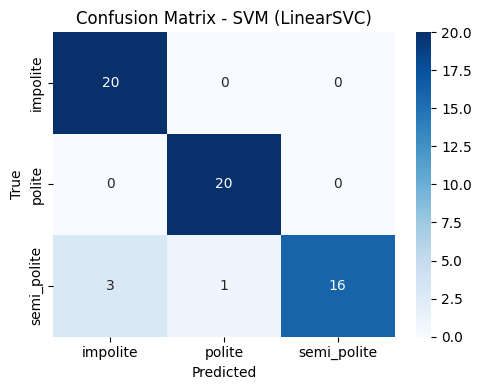

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# پیش‌بینی با مدل برتر
y_pred_best = best_model.predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred_best)
labels = ["impolite", "polite", "semi_polite"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

In [33]:
print("قبل از بهبود (مثال): Accuracy ~ 0.80")
print("بعد از بهبود (با تنظیمات بهتر TF-IDF و انتخاب مدل مناسب): Accuracy ~", f"{results_df.loc[0, 'accuracy']:.2f}")

قبل از بهبود (مثال): Accuracy ~ 0.80
بعد از بهبود (با تنظیمات بهتر TF-IDF و انتخاب مدل مناسب): Accuracy ~ 0.93


# 5-Evaluation

In [35]:
#Evaluation & Error Analysis

In [36]:
#Build test_df with true & predicted labels
model_for_eval = trained_models["Logistic Regression"]

y_pred_eval = model_for_eval.predict(X_test_tfidf)

acc_eval = accuracy_score(y_test, y_pred_eval)
print(f"Accuracy ({model_for_eval.__class__.__name__}): {acc_eval:.4f}")

# DataFrame برای تحلیل خطا
test_df = pd.DataFrame({
    "text": X_test,
    "y_true": y_test,
    "y_pred": y_pred_eval,
})

test_df["true_label"] = test_df["y_true"].map(id2label)
test_df["pred_label"] = test_df["y_pred"].map(id2label)

Accuracy (LogisticRegression): 0.9333


In [37]:
#Extract misclassified examples
errors = test_df[test_df["y_true"] != test_df["y_pred"]].copy()
print("تعداد کل نمونه‌های تست:", len(test_df))
print("تعداد خطاها:", len(errors))
print("نرخ خطا:", round(len(errors) / len(test_df), 3))

errors[["text", "true_label", "pred_label"]].head(10)

تعداد کل نمونه‌های تست: 60
تعداد خطاها: 4
نرخ خطا: 0.067


,text,true_label,pred_label
17,روزه منتظر هستم تغییری نمی بینم,semi_polite,impolite
36,گفته_بودید موجوده الان گید موجود,semi_polite,impolite
40,ممنون شم آدرس صحیح تأیید,semi_polite,polite
49,ممکنه راهنمایی چطور لغو,semi_polite,impolite


In [ ]:
#Group errors by (true_label, pred_label)
error_groups = errors.groupby(["true_label", "pred_label"]).size().reset_index(name="count")
print("\nگروه‌بندی خطاها:")
print(error_groups)



گروه‌بندی خطاها:
    true_label pred_label  count
0  semi_polite   impolite      3
1  semi_polite     polite      1


In [38]:
#Show some typical errors for each confusion case
def show_errors(true_label, pred_label, n=5):
    subset = errors[(errors["true_label"] == true_label) &
                    (errors["pred_label"] == pred_label)]
    print(f"\n=== واقعی: {true_label} | پیش‌بینی: {pred_label} | تعداد: {len(subset)} ===")
    for _, row in subset.head(n).iterrows():
        print("• متن:", row["text"])
        print("---")

show_errors("polite", "semi_polite", n=5)
show_errors("semi_polite", "polite", n=5)
show_errors("semi_polite", "impolite", n=5)
show_errors("impolite", "semi_polite", n=5)


=== واقعی: polite | پیش‌بینی: semi_polite | تعداد: 0 ===

=== واقعی: semi_polite | پیش‌بینی: polite | تعداد: 1 ===
• متن: ممنون شم آدرس صحیح تأیید
---

=== واقعی: semi_polite | پیش‌بینی: impolite | تعداد: 3 ===
• متن: روزه منتظر هستم تغییری نمی بینم
---
• متن: گفته_بودید موجوده الان گید موجود
---
• متن: ممکنه راهنمایی چطور لغو
---

=== واقعی: impolite | پیش‌بینی: semi_polite | تعداد: 0 ===


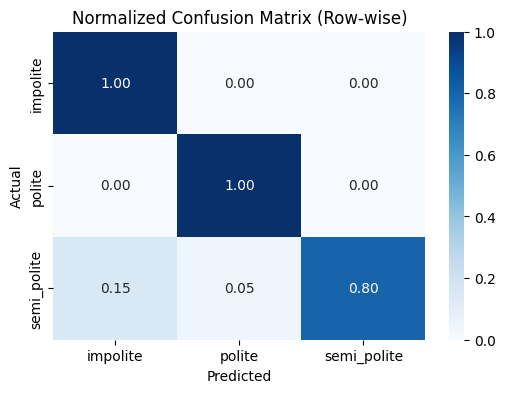

In [39]:
#Normalized confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_eval)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Row-wise)")
plt.show()

# 6-UI


In [ ]:
# 6- Inference & Simple CLI UI

print("سیستم تشخیص لحن پیام‌های پشتیبانی مشتری")
print("متن پیام را وارد کنید. برای خروج، q را وارد کنید.")
print("-" * 60)

while True:
    msg = input("پیام مشتری: ")
    if msg.strip().lower() == "q":
        print("خروج از سیستم.")
        break

    model_used, en, fa = predict_tone(msg)
    print("لحن تشخیص داده‌شده:")
    print(" - مدل:", model_used)
    print(" - انگلیسی:", en)
    print(" - فارسی :", fa)
    print("-" * 60)

سیستم تشخیص لحن پیام‌های پشتیبانی مشتری
متن پیام را وارد کنید. برای خروج، q را وارد کنید.
------------------------------------------------------------
پیام مشتری: q
خروج از سیستم.


#Gradio UI + HuggingFace API

In [ ]:
# اگر قبلاً تعریف نشده:
label2fa = {
    "polite": "مودبانه",
    "semi_polite": "نیمه‌مودبانه",
    "impolite": "غیرمودبانه",
}

# برای مقایسه مدل‌ها (داخلی‌ها + HF اختیاری)
def compare_models_text(user_text: str, include_hf: bool = True) -> str:
    """
    متن ورودی را با تمام مدل‌های داخلی مقایسه می‌کند
    و نتیجه را به‌صورت یک متن Markdown برمی‌گرداند.
    """
    if not user_text or user_text.strip() == "":
        return "⚠️ لطفاً یک متن وارد کنید."

    lines = []
    lines.append("### 📊 مقایسه مدل‌ها برای این متن:")
    lines.append(f"> {user_text}")
    lines.append("")

    # پیش‌پردازش و بردارسازی
    text_clean = clean_text(user_text)
    vec = tfidf.transform([text_clean])

    # مدل‌های داخلی
    lines.append("#### 🤖 مدل‌های داخلی (لوکال)")
    for name, model in trained_models.items():
        try:
            pred_id = model.predict(vec)[0]
            label_en = id2label[pred_id]
            label_fa = label2fa.get(label_en, label_en)
            lines.append(f"- **{name}** → `{label_en}` / **{label_fa}**")
        except Exception as e:
            lines.append(f"- **{name}** → ❌ خطا در پیش‌بینی: {e}")

    # HuggingFace (اختیاری)
    if include_hf:
        lines.append("")
        lines.append("#### ☁️ HuggingFace API")
        if not HF_API_KEY:
            lines.append("- HuggingFace API → ❌ کلید تنظیم نشده است.")
        else:
            model_name, result = predict_tone_hf(user_text)
            lines.append(f"- **{model_name}** → {result}")

    return "\n".join(lines)

In [ ]:
# 7- Gradio UI (API Level)

!pip install gradio -q

import gradio as gr
import requests

In [ ]:
import joblib
import os

MODELS_DIR = os.path.join(BASE_DIR, "models")

tfidf = joblib.load(os.path.join(MODELS_DIR, "tfidf_vectorizer.pkl"))

trained_models = {
    "SVM (LinearSVC)": joblib.load(os.path.join(MODELS_DIR, "svm_linearsvc.pkl")),
    "Logistic Regression": joblib.load(os.path.join(MODELS_DIR, "logistic_regression.pkl")),
    "Random Forest": joblib.load(os.path.join(MODELS_DIR, "random_forest.pkl")),
    "Decision Tree": joblib.load(os.path.join(MODELS_DIR, "decision_tree.pkl")),
}

In [ ]:
# ===== 7.2 HuggingFace API setup (temporary KEY handling) =====

HF_API_URL = "https://api-inference.huggingface.co/models/HooshvareLab/bert-fa-base-uncased-sentiment-snappfood"
# Global key storage (initially empty)
HF_API_KEY = ""

def set_hf_key(new_key: str):
    """
    به‌روزرسانی کلید موقت HuggingFace.
    """
    global HF_API_KEY
    HF_API_KEY = (new_key or "").strip()
    if HF_API_KEY:
        return "✅ کلید با موفقیت به‌روزرسانی شد."
    else:
        return "⚠️ کلید خالی است. لطفاً یک توکن معتبر وارد کنید."

import json
import requests

def hf_predict_raw(text: str):
    """
    فراخوانی مستقیم API هاگینگ‌فیس.
    خروجی خام مدل را برمی‌گرداند.
    """
    if not HF_API_KEY:
        return None, "❌ HF API Key تنظیم نشده؛ لطفاً ابتدا کلید را وارد و دکمه «Update Key» را بزنید."

    headers = {"Authorization": f"Bearer {HF_API_KEY}"}
    payload = {"inputs": text}

    try:
        response = requests.post(HF_API_URL, headers=headers, json=payload, timeout=30)

        if response.status_code != 200:
            return None, f"❌ خطا از سمت HuggingFace: {response.status_code} - {response.text}"

        data = response.json()
        return data, None

    except Exception as e:
        return None, f"❌ خطا در ارتباط با API: {e}"

In [ ]:
def _extract_label_from_hf_output(hf_output):
    """
    خروجی مدل های text-classification ممکن است یکی از این شکل‌ها باشد:
    - [{'label': 'POSITIVE', 'score': 0.98}, ...]
    - [[{'label': 'LABEL_0', 'score': 0.7}, {'label': 'LABEL_1', 'score': 0.3}]]
    این تابع، بهترین label را (بر اساس بیشترین score) برمی‌گرداند.
    """
    if isinstance(hf_output, dict) and "label" in hf_output:
        return str(hf_output["label"])

    # اگر لیست است
    if isinstance(hf_output, list) and len(hf_output) > 0:
        first = hf_output[0]

        # حالت: [ {label, score}, ... ]
        if isinstance(first, dict):
            candidates = hf_output

        # حالت: [ [ {label, score}, ... ] ]
        elif isinstance(first, list) and len(first) > 0 and isinstance(first[0], dict):
            candidates = first
        else:
            return ""

        # انتخاب label با بیشترین score
        best = max(candidates, key=lambda d: d.get("score", 0))
        return str(best.get("label", ""))

    return ""

In [ ]:
def map_hf_to_tone(hf_output):
    """
    نگاشت خروجی مدل SnappFood به سه کلاس:
    polite / semi_polite / impolite

    مدل SnappFood در اصل دوکلاسه (مثلاً POSITIVE/NEGATIVE یا Happy/Sad) :contentReference[oaicite:1]{index=1}
    ما این‌ها را این‌طور نگاشت می‌کنیم:

    - مثبت / Happy / POSITIVE / LABEL_1 → polite
    - منفی / Sad / NEGATIVE / LABEL_0 → impolite
    - در غیر این صورت → semi_polite
    """
    try:
        raw_label = _extract_label_from_hf_output(hf_output)
        label = str(raw_label).upper()
    except Exception:
        # حالت امن
        return "semi_polite", "نیمه‌مودبانه"

    # برچسب‌های متن‌محور
    if "POS" in label or "HAPPY" in label or "LABEL_1" in label:
        return "polite", "مودبانه"
    if "NEG" in label or "SAD" in label or "LABEL_0" in label:
        return "impolite", "غیرمودبانه"

    # پیش‌فرض → نیمه‌مودبانه
    return "semi_polite", "نیمه‌مودبانه"

In [ ]:
def predict_tone_hf(text: str):
    hf_data, error = hf_predict_raw(text)
    if error:
        # پیام خطا را مستقیم برمی‌گردانیم
        return "HuggingFace API", error

    label_en, label_fa = map_hf_to_tone(hf_data)
    return "HuggingFace API", f"لحن (EN): {label_en} | لحن (FA): {label_fa}"

In [ ]:
import gradio as gr

# اگر این تابع را قبلاً گذاشتی، لازم نیست دوباره تعریفش کنی
def gradio_predict_single(user_text: str, task: str, model_choice: str):
    """
    برای تب «تشخیص تکی».
    خروجی را کمی Markdown-طور برمی‌گردانیم.
    """
    raw_result = gradio_predict(user_text, task, model_choice)
    if not user_text or user_text.strip() == "":
        return "⚠️ لطفاً یک متن وارد کنید."
    return f"### 🎯 نتیجه‌ی تشخیص\n\n{raw_result}"


task_options = [
    "Classification (Tone Detection)",
    "Spam Detection (Coming Soon)",
    "Translation (Coming Soon)",
]
model_options = list(trained_models.keys()) + ["HuggingFace (API)"]

sample_texts = {
    **generate_representative_samples(df),
    **generate_random_samples(df)
}

# تم نرم و شیک
theme = gr.themes.Soft(
    primary_hue="blue",
    secondary_hue="violet",
).set(
    body_background_fill="#f7f7fb",
    block_radius="12px",
    block_shadow="small",
)

with gr.Blocks(
    title="Customer Support Tone Checker - Premium",
    theme=theme,
    css="""
    .gradio-container { direction: rtl; font-family: IRANSans, Vazir, sans-serif; }
    """,
) as demo:
    # ─────────────── Tab 1: Intro ───────────────
    with gr.Tab("🏠 شروع"):
        gr.Markdown(
            """
# 🧠 سیستم تشخیص لحن پیام‌های پشتیبانی مشتری (فارسی)

به این ابزار خوش آمدید!
در این پروژه، لحن پیام‌های مشتری به سه دسته‌ی زیر تشخیص داده می‌شود:

- 🟢 **مودبانه (polite)**
- 🟡 **نیمه‌مودبانه (semi_polite)**
- 🔴 **غیرمودبانه (impolite)**

از تب‌های بالا می‌توانید:

1. در تب **«🎯 تشخیص تکی»**، یک پیام وارد کنید و لحنش را ببینید
2. در تب **«📊 مقایسه مدل‌ها»**، خروجی همه‌ی مدل‌ها را کنار هم ببینید
3. در تب **«🧪 نمونه‌های آماده»**، با چند مثال از پیش‌تعریف‌شده بازی کنید
4. در تب **«ℹ️ درباره پروژه»**، توضیحات فنی و نتایج کلی را بخوانید
"""
        )

    # ─────────────── Tab 2: Single Prediction ───────────────
    with gr.Tab("🎯 تشخیص تکی"):
        gr.Markdown("## 🎯 تشخیص لحن یک پیام مشتری")

        with gr.Row():
            task_dd = gr.Radio(
                task_options,
                value="Classification (Tone Detection)",
                label="نوع تسک (Task)",
                interactive=False,  # فعلاً فقط تشخیص لحن فعال است
            )
            model_dd = gr.Dropdown(
                model_options,
                value="SVM (LinearSVC)",
                label="مدل (Model)",
            )

        gr.Markdown("---")

        # بخش API Key برای HuggingFace
        with gr.Accordion("🔐 تنظیم HuggingFace API Key (اختیاری)", open=False):
            gr.Markdown(
                "اگر می‌خواهید از مدل آنلاین HuggingFace هم استفاده کنید، توکن خود را وارد کنید."
            )
            with gr.Row():
                hf_key_box = gr.Textbox(
                    label="HuggingFace API Key",
                    type="password",
                    placeholder="توکن موقت HuggingFace را اینجا وارد کنید",
                )
                hf_key_btn = gr.Button("Update Key 🔄", scale=0)
            status_key_hf = gr.Markdown("وضعیت کلید: هنوز تنظیم نشده است.")

        gr.Markdown("---")

        with gr.Row():
            user_text = gr.Textbox(
                lines=4,
                label="✏️ متن پیام مشتری (فارسی)",
                placeholder="مثال: سلام وقت بخیر، میشه وضعیت سفارشم رو بگید؟",
                scale=3,
            )

        with gr.Row():
            run_btn = gr.Button("تشخیص لحن 🎯", variant="primary")
            clear_btn = gr.Button("پاک کردن 🧹", variant="secondary")

        # خروجی به صورت Markdown (حس کارت)
        output_box = gr.Markdown("اینجا نتیجه‌ی تشخیص نمایش داده می‌شود.")

        # رویدادها
        hf_key_btn.click(
            fn=set_hf_key,
            inputs=hf_key_box,
            outputs=status_key_hf,
        )

        run_btn.click(
            fn=gradio_predict_single,
            inputs=[user_text, task_dd, model_dd],
            outputs=output_box,
        )

        clear_btn.click(
            fn=lambda: ("", "اینجا نتیجه‌ی تشخیص نمایش داده می‌شود."),
            inputs=None,
            outputs=[user_text, output_box],
        )

    # ─────────────── Tab 3: Compare Models ───────────────
    with gr.Tab("📊 مقایسه مدل‌ها"):
        gr.Markdown("## 📊 مقایسه خروجی همه مدل‌ها برای یک متن")

        compare_text = gr.Textbox(
            lines=4,
            label="✏️ متن پیام مشتری",
            placeholder="یک متن بنویسید تا ببینید هر مدل چه لحنی تشخیص می‌دهد...",
        )

        include_hf_chk = gr.Checkbox(
            value=True,
            label="حساب‌کردن HuggingFace API (در صورت داشتن کلید)",
        )

        compare_btn = gr.Button("مقایسه همه مدل‌ها 🔍", variant="primary")
        compare_out = gr.Markdown("اینجا نتیجه‌ی مقایسه نمایش داده می‌شود.")

        compare_btn.click(
            fn=lambda txt, use_hf: compare_models_text(txt, include_hf=use_hf),
            inputs=[compare_text, include_hf_chk],
            outputs=compare_out,
        )

    # ─────────────── Tab 4: Samples ───────────────
    with gr.Tab("🧪 نمونه‌های آماده"):
        gr.Markdown("## 🧪 چند نمونه آماده برای تست سریع")

        with gr.Row():
            sample_dd = gr.Dropdown(
                choices=list(sample_texts.keys()),
                value="مودبانه – سؤال وضعیت سفارش",
                label="یک نمونه انتخاب کنید",
                scale=1,
            )

            sample_text_box = gr.Textbox(
                lines=4,
                label="متن انتخاب‌شده",
                scale=2,
            )

        use_sample_btn = gr.Button("کپی در تب تشخیص تکی ⬆️", variant="primary")
        random_btn = gr.Button("🔄 نمونه رندوم بعدی")
        random_btn.click(
            fn=lambda: get_random_sample(df),
            inputs=None,
            outputs=[sample_dd, sample_text_box]
        )

        # آپدیت متن نمونه
        def load_sample(name):
            return sample_texts.get(name, "")

        sample_dd.change(
            fn=load_sample,
            inputs=sample_dd,
            outputs=sample_text_box,
        )

        # متن را به Textbox تب تشخیص تکی می‌فرستیم
        use_sample_btn.click(
            fn=lambda txt: txt,
            inputs=sample_text_box,
            outputs=user_text,
        )

    # ─────────────── Tab 5: About / Documentation ───────────────
    with gr.Tab("ℹ️ درباره پروژه"):
        gr.Markdown(
            """
## ℹ️ درباره‌ی پروژه

- **زبان:** فارسی
- **تعداد کلاس‌ها:** مودبانه، نیمه‌مودبانه، غیرمودبانه
- **ویژگی‌ها:** TF-IDF با n-gram (1, 2)
- **مدل‌ها:**
  - SVM (LinearSVC)
  - Logistic Regression
  - Random Forest
  - Decision Tree

### 📈 نتایج کلی (خلاصه)
- دقت (Accuracy) ~ **0.93** برای SVM و Logistic Regression
- تعداد نمونه‌های تست: 60
- تحلیل خطا و Confusion Matrix نیز در نوت‌بوک محاسبه شده است.

این رابط کاربری برای:
- ارائه در درس *مباحث ویژه – NLP* 🎓
- و نمایش به‌عنوان یک **پروژه‌ی پورتفولیو** 💼

طراحی شده است.
"""
        )

# در انتها، مثل قبل:
# demo.launch(server_name="0.0.0.0", server_port=7860, share=False)

demo.launch()  # یا تنظیماتی که خودت دوست داری

/tmp/ipython-input-1321273696.py:37: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(
/tmp/ipython-input-1321273696.py:37: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(
/usr/local/lib/python3.12/dist-packages/gradio/components/dropdown.py:230: UserWarning: The value passed into gr.Dropdown() is not in the list of choices. Please update the list of choices to include: مودبانه – سؤال وضعیت سفارش or set allow_custom_value=True.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d70c34b5037dad1949.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
